In [154]:
!pip install torchdiffeq

In [155]:
import os
import argparse
import time
import psutil
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from torchdiffeq import odeint

In [156]:
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [157]:
train_mat = scipy.io.loadmat('../input/npdetest/S_train_20.mat')
params_train_mat = scipy.io.loadmat('../input/npdetest/params_train_20.mat')
test_mat = scipy.io.loadmat('../input/npdetest/S_test_20_extended.mat')
params_test_mat = scipy.io.loadmat('../input/npdetest/params_test_20_extended.mat')

In [158]:
train_data = torch.tensor(train_mat['S'])
params_train_data = torch.tensor(params_train_mat['I'])
test_data = torch.tensor(test_mat['S'])
params_test_data = torch.tensor(params_test_mat['I'])

In [159]:
train_data = torch.transpose(train_data[:,:400],0, 1).unsqueeze(1)

In [160]:
train_data.shape

torch.Size([400, 1, 256])

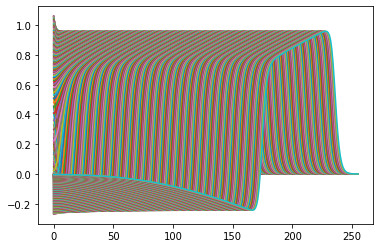

In [161]:
for i in range(0,400):
   plt.plot(train_data[i,:,:].flatten())
   #print(params_train_data[i])

In [162]:
data_size = train_data.shape[0]
print(data_size)
batch_time = 20
batch_size = 32
n_hidden = 50
method = 'dopri5'
test_freq = 50
epochs = 2000

400


In [163]:
def get_batch():
    batch_t = torch.arange(batch_time).float()
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time), batch_size, replace=False))
    
    batch_u0 = train_data[s,:,:].float()
    batch_u = torch.stack([train_data[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s

In [164]:
def get_batch_test(t0,test_batch_time):
    batch_t = torch.arange(test_batch_time-t0).float()
    s = torch.tensor([t0])
    batch_u0 = train_data[s,:,:].float()
    batch_u = torch.stack([train_data[s+i,:,:] for i in range(test_batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s

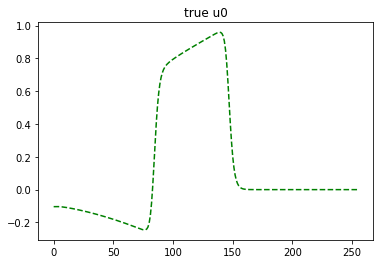

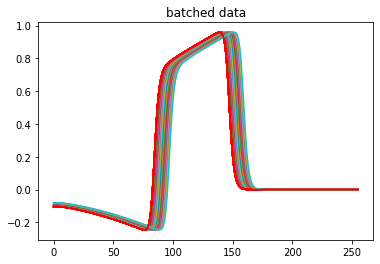

In [165]:
batch_u0, batch_u, batch_t, s = get_batch()
batch_element = 2
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].cpu().flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')

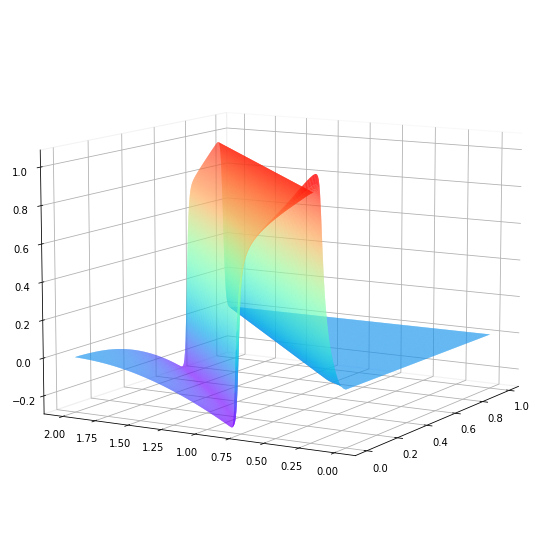

In [166]:
t = np.linspace(0, 2, 400)
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data.squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000,alpha=1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(10, 210)

In [167]:
batch_u0.shape

torch.Size([32, 1, 256])

In [168]:
# DIM TEST
input_ = batch_u0.cpu()
output = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same',dilation=1)(input_)
output = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same',dilation=2)(output)
output = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same',dilation=4)(output)
output = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding='same',dilation=8)(output)
output = nn.BatchNorm1d(1)(output)
#output = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=1)(output)
output.shape


torch.Size([32, 1, 256])

In [169]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(256, n_hidden),
            nn.ELU(),
            nn.Linear(n_hidden, 256)
        )

        
        self.nfe=0
        self.net[0].weight.data.normal_(0.0, 1/n_hidden)
        self.net[0].bias.data.fill_(.0)
        self.net[2].weight.data.normal_(0.0, 1/n_hidden)
        self.net[2].bias.data.fill_(.0)

    def forward(self, t, y):
        self.nfe += 1
        return self.net(y)

In [170]:
class ConvODEFunc(nn.Module):
    def __init__(self):
        super(ConvODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding='same')
        )
        self.net[0].weight.data.normal_(0.0, 1/(16*3*3))
        self.net[0].bias.data.fill_(.0)
        self.net[2].weight.data.normal_(0.0, 1/(16*3*3))
        self.net[2].bias.data.fill_(.0)
        
    def forward(self, t, y):
        return self.net(y)

In [171]:
func = ConvODEFunc().to(device)

In [172]:
ii = 0
lrate = 1e-3


optimizer = optim.Adam(func.parameters(), lr=lrate)

loss_array = []
itr_time = []
start = time.time()

for itr in range(1, epochs + 1):

    start_itr = time.time()

    batch_u0, batch_u, batch_t, s = get_batch()
    pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)

    loss = torch.mean(torch.pow(pred_u - batch_u,2))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    itr_time.append(time.time()-start_itr)
    loss_array.append(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            print('Iter ' + str(itr)+'/'+str(epochs) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5)))
            #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
            #       ii += 1

total_elapsed_time = time.time()-start

Iter 50/2000	|  Loss: 0.016372	|  lr: 0.001	|  itr time: 0.09805
Iter 100/2000	|  Loss: 0.004933	|  lr: 0.001	|  itr time: 0.26609
Iter 150/2000	|  Loss: 0.002398	|  lr: 0.001	|  itr time: 0.39454
Iter 200/2000	|  Loss: 0.002072	|  lr: 0.001	|  itr time: 0.31447
Iter 250/2000	|  Loss: 0.002153	|  lr: 0.001	|  itr time: 0.31915
Iter 300/2000	|  Loss: 0.001952	|  lr: 0.001	|  itr time: 0.33347
Iter 350/2000	|  Loss: 0.001076	|  lr: 0.001	|  itr time: 0.31062
Iter 400/2000	|  Loss: 0.0012	|  lr: 0.001	|  itr time: 0.35576
Iter 450/2000	|  Loss: 0.000801	|  lr: 0.001	|  itr time: 0.37782
Iter 500/2000	|  Loss: 0.001514	|  lr: 0.001	|  itr time: 0.42921
Iter 550/2000	|  Loss: 0.000761	|  lr: 0.001	|  itr time: 0.36548
Iter 600/2000	|  Loss: 0.001003	|  lr: 0.001	|  itr time: 0.35889
Iter 650/2000	|  Loss: 0.000999	|  lr: 0.001	|  itr time: 0.34809
Iter 700/2000	|  Loss: 0.000742	|  lr: 0.001	|  itr time: 0.35852
Iter 750/2000	|  Loss: 0.000516	|  lr: 0.001	|  itr time: 0.39671
Iter 800/2000

In [173]:
batch_u0, batch_u, batch_t, s = get_batch_test(100,200)
batch_u0.shape, batch_u.shape, batch_t.shape
pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)   

In [174]:
batch_u.shape

torch.Size([200, 1, 1, 256])

<Figure size 432x288 with 0 Axes>

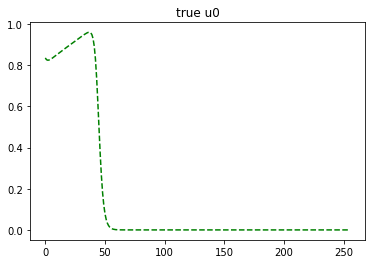

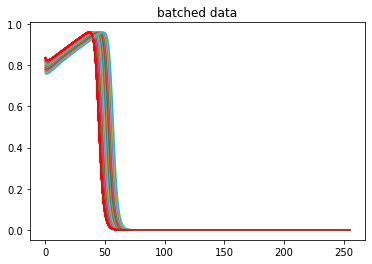

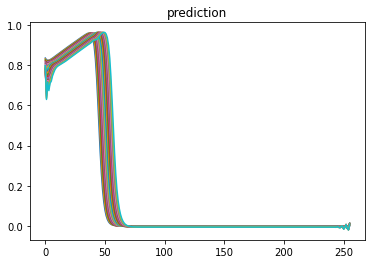

In [175]:
plt.figure().patch.set_facecolor('#FFFFFF')

batch_element = 0
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(20):
  plt.plot(pred_u[j,batch_element,:,:].cpu().detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])

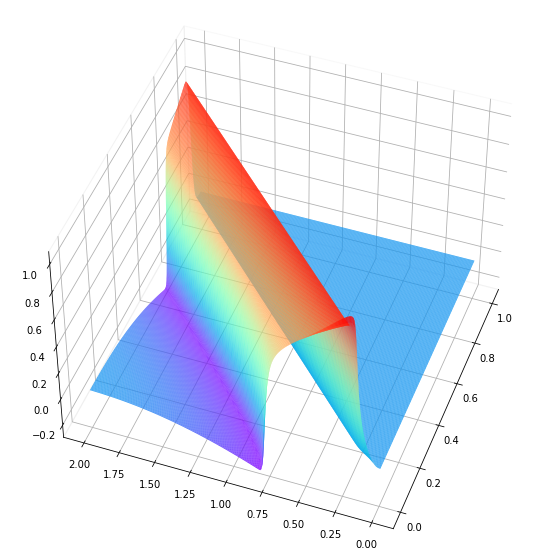

In [176]:
t = np.linspace(0, 2, 400)
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data.squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(45, 200)

In [177]:
pred_u.shape

torch.Size([100, 1, 1, 256])

In [178]:
t0 = 300
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = train_data[t0,:,:].unsqueeze(0).float().to(device)   
pred_u0.shape

torch.Size([1, 1, 256])

In [179]:
pred_u = odeint(func, pred_u0, pred_t,method=method).to(device)   

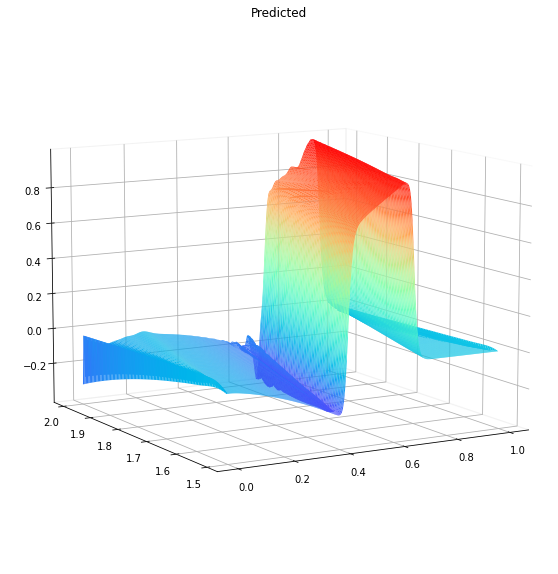

In [180]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = pred_u.squeeze(1).squeeze(1).detach().cpu().numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('Predicted')
ax.view_init(10, 240)

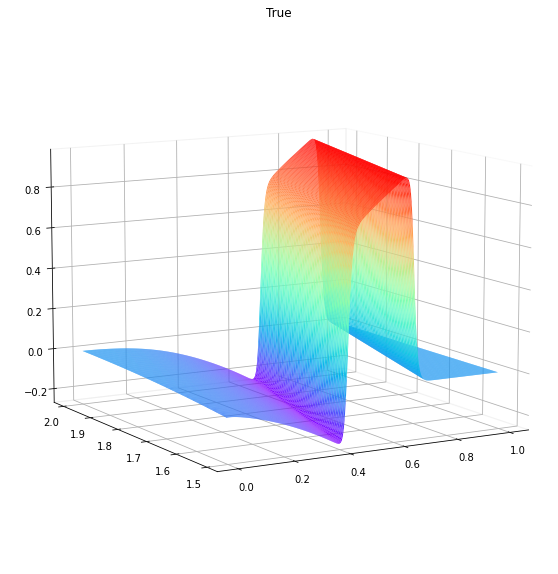

In [181]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data[t0:,:].squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('True')
ax.view_init(10, 240)

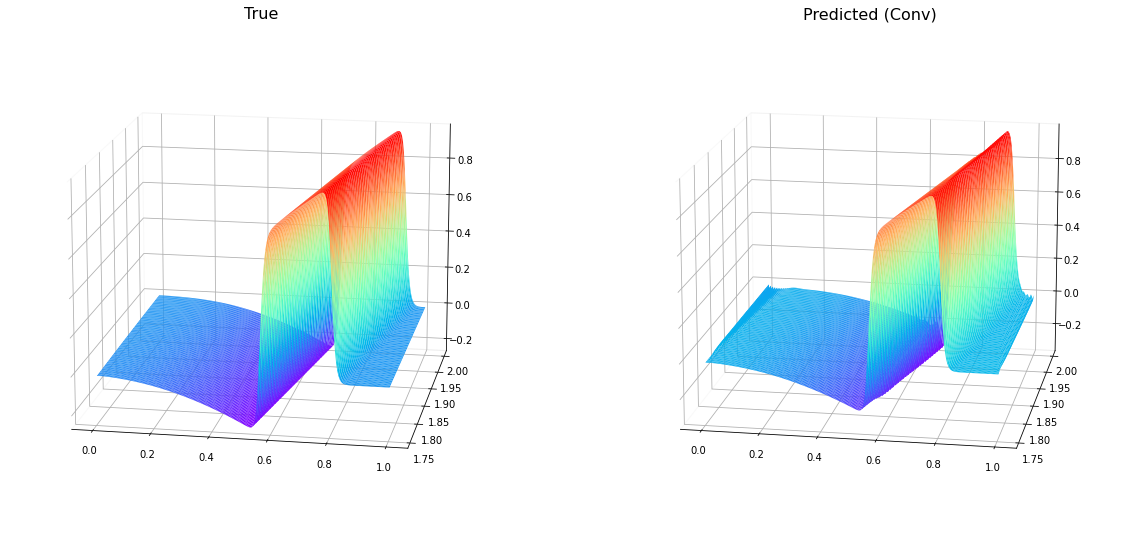

In [182]:
t0 = 350
angle1 = 15
angle2 = 280
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data[t0:,:].squeeze(1).numpy()
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.set_title('True',fontsize=16)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(angle1, angle2)

pred_t = torch.arange(400-t0).float().to(device)
pred_u0 = train_data[t0,:,:].unsqueeze(0).float().to(device)
pred_u0.shape
pred_u = odeint(func, pred_u0, pred_t,method=method).to(device)   
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = pred_u.squeeze(1).squeeze(1).detach().cpu().numpy()

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.set_title('Predicted (Conv)',fontsize=16)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(angle1, angle2)

plt.savefig('double.png',dpi=200)

In [183]:
mse = torch.mean(torch.pow(train_data[t0:,:]-pred_u.cpu().squeeze(1),2))
mse

tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)

<Figure size 432x288 with 0 Axes>

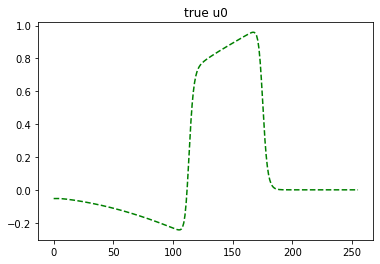

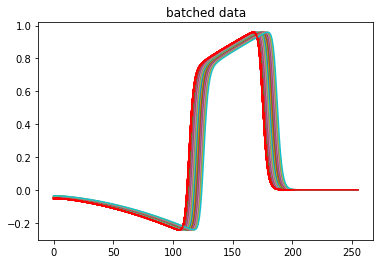

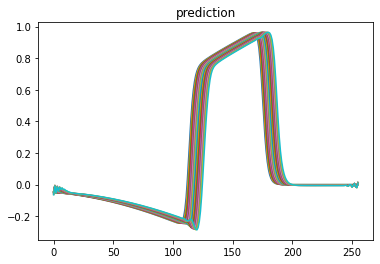

In [184]:
batch_u0, batch_u, batch_t, s = get_batch()
batch_u0.shape, batch_u.shape, batch_t.shape
pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)   

plt.figure().patch.set_facecolor('#FFFFFF')

batch_element = 2
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(batch_time):
  plt.plot(pred_u[j,batch_element,:,:].cpu().detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])